In [6]:
import pandas as pd

df_demo = pd.read_csv("../data/df_final_demo.txt", delimiter=",")
df_web_pt1 = pd.read_csv("../data/df_final_web_data_pt_1.txt", delimiter=",")
df_web_pt2 = pd.read_csv("../data/df_final_web_data_pt_2.txt", delimiter=",")
df_experiment = pd.read_csv("../data/df_final_experiment_clients.txt", delimiter=",")


In [7]:
print("df_demo shape:", df_demo.shape)
print("df_web_pt1 shape:", df_web_pt1.shape)
print("df_web_pt2 shape:", df_web_pt2.shape)
print("df_experiment shape:", df_experiment.shape)


df_demo shape: (70609, 9)
df_web_pt1 shape: (343141, 5)
df_web_pt2 shape: (412264, 5)
df_experiment shape: (70609, 2)


In [8]:
df_web = pd.concat([df_web_pt1, df_web_pt2], ignore_index=True)
print("df_web shape after merge:", df_web.shape)


df_web shape after merge: (755405, 5)


In [9]:
print("df_demo columns:", df_demo.columns.tolist())
print("df_experiment columns:", df_experiment.columns.tolist())


df_demo columns: ['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
df_experiment columns: ['client_id', 'Variation']


In [10]:
df_clients = pd.merge(df_experiment, df_demo, on="client_id", how="left")
print("df_clients shape:", df_clients.shape)


df_clients shape: (70609, 10)


In [11]:
df_full = pd.merge(df_web, df_clients, on="client_id", how="left")
print("df_full shape:", df_full.shape)


df_full shape: (755405, 14)


In [12]:
missing_summary = df_full.isna().sum()
print(missing_summary)


client_id                0
visitor_id               0
visit_id                 0
process_step             0
date_time                0
Variation           434096
clnt_tenure_yr      305689
clnt_tenure_mnth    305689
clnt_age            305701
gendr               305689
num_accts           305689
bal                 305689
calls_6_mnth        305689
logons_6_mnth       305689
dtype: int64


In [13]:
df_full.describe()


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,7.554050e+05,449716.000000,449716.000000,449704.000000,449716.000000,4.497160e+05,449716.000000,449716.000000
mean,5.013632e+06,12.234130,152.810921,47.653966,2.264767,1.597737e+05,3.529176,5.709877
std,2.879152e+06,7.005183,83.719616,15.742089,0.543074,3.420694e+05,2.242472,2.356178
min,1.690000e+02,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519882e+06,6.000000,82.000000,33.500000,2.000000,3.844801e+04,2.000000,4.000000
50%,5.033441e+06,11.000000,139.000000,49.000000,2.000000,6.677490e+04,3.000000,6.000000
75%,7.496063e+06,16.000000,194.000000,60.000000,2.000000,1.490039e+05,6.000000,8.000000
max,9.999875e+06,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


In [14]:
categorical_cols = df_full.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    print(f"{col} unique values:", df_full[col].nunique())


visitor_id unique values: 130236
visit_id unique values: 158095
process_step unique values: 5
date_time unique values: 629363
Variation unique values: 2
gendr unique values: 4


In [15]:
df_full.to_csv("../data/df_full_merged.csv", index=False)


In [16]:
# Count of clients by gender
print(df_clients['gendr'].value_counts())

# Age statistics
print(df_clients['clnt_age'].describe())

# Tenure statistics
print(df_clients['clnt_tenure_yr'].describe())


gendr
U    24122
M    23724
F    22746
X        3
Name: count, dtype: int64
count    70594.000000
mean        46.442240
std         15.591273
min         13.500000
25%         32.500000
50%         47.000000
75%         59.000000
max         96.000000
Name: clnt_age, dtype: float64
count    70595.000000
mean        12.052950
std          6.871819
min          2.000000
25%          6.000000
50%         11.000000
75%         16.000000
max         62.000000
Name: clnt_tenure_yr, dtype: float64


In [17]:
# Count of clients per experiment variation
print(df_clients['Variation'].value_counts())


Variation
Test       26968
Control    23532
Name: count, dtype: int64


In [18]:
# Assuming process_step indicates completion at the last step (e.g., step 4)
final_step = df_full['process_step'].max()

completion = df_full[df_full['process_step'] == final_step].groupby('Variation')['client_id'].nunique()
total_per_group = df_clients.groupby('Variation')['client_id'].nunique()

completion_rate = (completion / total_per_group) * 100
print(completion_rate)


Variation
Control    74.035356
Test       77.428805
Name: client_id, dtype: float64


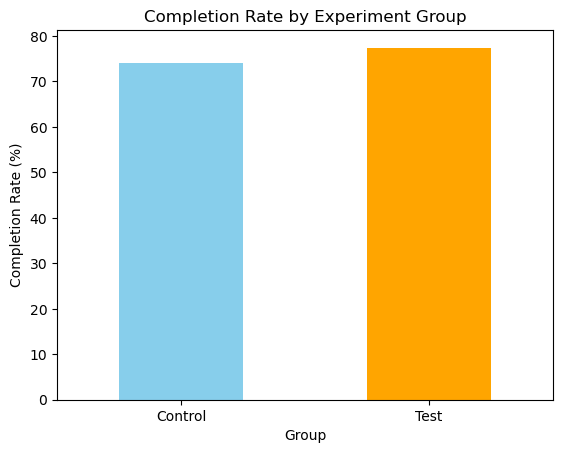

In [19]:
import matplotlib.pyplot as plt

completion_rate.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Completion Rate by Experiment Group")
plt.ylabel("Completion Rate (%)")
plt.xlabel("Group")
plt.xticks(rotation=0)
plt.show()


In [20]:
# Example: average number of logons and calls in the past 6 months by experiment group
engagement_metrics = df_clients.groupby('Variation')[['logons_6_mnth', 'calls_6_mnth']].mean()
print(engagement_metrics)


           logons_6_mnth  calls_6_mnth
Variation                             
Control         6.166277      3.129213
Test            6.101851      3.061941


In [22]:
final_step = df_full['process_step'].max()

df_completion = df_full.groupby('client_id')['process_step'].apply(
    lambda steps: 1 if (steps == final_step).any() else 0
).reset_index(name='completed')

# Merge with experiment variation
df_completion = pd.merge(df_completion, df_clients[['client_id','Variation']], on='client_id', how='left')
print(df_completion.head())



   client_id  completed Variation
0        169          1       NaN
1        336          0       NaN
2        546          1       NaN
3        555          1      Test
4        647          1      Test


In [23]:
from statsmodels.stats.proportion import proportions_ztest

# Counts of completed clients per group
completed_counts = df_completion.groupby('Variation')['completed'].sum()
# Total clients per group
total_counts = df_completion.groupby('Variation')['completed'].count()

z_stat, p_val = proportions_ztest(count=completed_counts, nobs=total_counts)
print("Z-statistic:", z_stat)
print("P-value:", p_val)


Z-statistic: -8.887872607199098
P-value: 6.229004058062662e-19


# Interpretation
- If p-value < 0.05: There is a statistically significant difference in completion rates between Control and Test groups.
- If p-value >= 0.05: There is no statistically significant difference in completion rates between the groups.



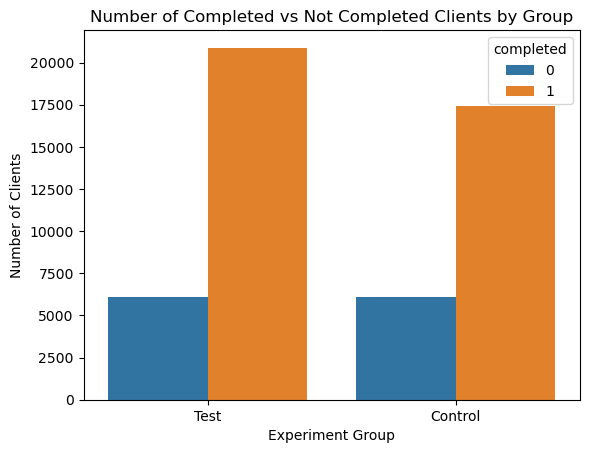

In [26]:
import seaborn as sns

sns.countplot(data=df_completion, x='Variation', hue='completed')
plt.title("Number of Completed vs Not Completed Clients by Group")
plt.ylabel("Number of Clients")
plt.xlabel("Experiment Group")
plt.show()


In [27]:
numeric_cols = ['clnt_age', 'clnt_tenure_yr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
group_stats = df_clients.groupby('Variation')[numeric_cols].agg(['mean','median','std'])
print(group_stats)


            clnt_age                   clnt_tenure_yr                   \
                mean median        std           mean median       std   
Variation                                                                
Control    47.498427   48.5  15.521781      12.087686   11.0  6.877531   
Test       47.163922   47.5  15.514461      11.982901   11.0  6.844947   

          num_accts                             bal                           \
               mean median       std           mean    median            std   
Variation                                                                      
Control    2.259914    2.0  0.538559  150147.326660  66024.18  295806.950360   
Test       2.249917    2.0  0.529335  148962.605032  65468.36  307373.713775   

          calls_6_mnth                  logons_6_mnth                   
                  mean median       std          mean median       std  
Variation                                                               
Control  

In [28]:
categorical_cols = ['gendr']
for col in categorical_cols:
    print(f"\n{col} distribution by Variation:")
    print(pd.crosstab(df_clients[col], df_clients['Variation']))



gendr distribution by Variation:
Variation  Control  Test
gendr                   
F             7543  8716
M             7970  8977
U             8014  9266
X                0     2


In [29]:
df_completion['cost_per_client'] = 5  # adjust if your project specifies a different cost
df_completion.head()


,client_id,completed,Variation,cost_per_client
0,169,1,NaN,5
1,336,0,NaN,5
2,546,1,NaN,5
3,555,1,Test,5
4,647,1,Test,5


In [30]:
df_completion.to_csv("../data/df_completion_ready.csv", index=False)


In [31]:
df_full.to_csv("../tableau/df_full_for_tableau.csv", index=False)


In [32]:
df_clients.to_csv("../data/df_clients_ready.csv", index=False)
